<h1 style='text-align:center;font-size:52px'>
    Airbus Use Case
    <h2 style="text-align:center;font-size:24px">
        Data Augmentation with GANs
    </h2>
</h1>

# Introduction

<div style="text-align:justify">We have a small dataset of images of electronic boards. We want to build a machine learning algorithm to detect defective components on the electronic boards. For this purpose, we want you to investigate different data augmentation strategies (especially ones using GANs) in order to increase the size of the training set and thereby improve the performance of the detector. The task will contain two sub-tasks and the second sub-task is optional. </div>

1.	Investigate different data augmentation strategies and create a synthetic training dataset
2.	Evaluate how different augmentation strategies affect the performance of the defective component detector (you can choose an appropriate metric).


<div style="text-align:justify">
The dataset is contains training images – both positive and negative examples. There are also some test images on which you can evaluate the performance (sub-task 2). Training labels are provided in a csv file that contains the bounding box of the defective component on the electronic board. In case, you choose to follow only the first sub-task, we will run an internal evaluation on how data augmentation affects the model performance. 
<br><br>
Note about the dataset: Files starting with “defect_” are the images containing defective components and the files starting with “real_” are images of boards not having any defective components. 
 </div>

# Implementation

## Import 

In [1]:
# Libraries Import
import numpy as np
import pickle
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, GaussianNoise, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Activation
# , MaxPooling2D, AveragePooling2D, Conv2DTranspose,, Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import binary_accuracy
# from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal
# from sklearn.model_selection import train_test_split
from numpy.random import randint, randn, choice, random
from glob import glob
from PIL import Image
from os import listdir
from os.path import isfile
from os.path import join

## Data Preparation
Preprocessing steps : 
> - Load all the images 800x600 as numpy array (shape : [800,600,3]). Then, downsize the resolution to 100x75. (2 functions available, one to save the output as new image, the other to save as pickle file containing the data) 
- For the numpy data, shift the range of values from [0:255] to [-1:1] (recommended range for GAN input)
- Save preprocessed dataset in pickle file which we will be able to load directly from this point. (allowing us to skip the all Data prepartion part). 

In [2]:
# Function for resizing the images used for the training and saving the output in images
def resizing_images(resized_width : int, resized_height : int, 
                    input_path : str, output_path : str):
    rns
    """Resizes the images from the original dataset
    
    The function takes as input the resized width and height of the images
    the path of the folder containing the original images 
    as well as the path of the folder containing the resized images 
    and returns the resized images in that folder
    
    Args: 
        resized_width (int): The width of the resized image
        resized_height (int): The height of the resized image
        input_path (str): The path of the folder containing the original images
        output_path (str): The path of the folder containing the resized images
    
    Returns:
        resized_image (jpeg): The resized images
    """
    
    # Check if output folder exists and create them if not
    if not os.path.isdir(output_path) :
        os.mkdir(output_path)
    
    files = [file for file in listdir(input_path) if isfile(join(input_path, file))]
    
    for file in files:
        if 'real' in file:
            file_name = input_path + file
            original_image = Image.open(file_name)
            resized_image = original_image.resize((resized_width,resized_height), Image.ANTIALIAS)
            resized_image.save(output_path+file[:-4]+'_'+str(resized_width)+str(resized_height)+'.jpg')

# Resizing images and save new image as jpeg

resized_width = 100
resized_height = 75

input_path_train = './train/'
output_path_train = f'./train_{resized_width}_{resized_height}/'

input_path_test = './test/'
output_path_test = f'./test_{resized_width}_{resized_height}/'

resizing_images(resized_width, resized_height, input_path_train, output_path_train)
resizing_images(resized_width, resized_height, input_path_test, output_path_test)


In [3]:
# Function to convert and save resized images to numpy arrays and save the output in pickle file
def resized_images_to_numpy(number_resized_images : int, resized_width : int, resized_height :int, 
                            number_of_channels : int, input_path : str, output_file_name : str):
    """Converts and saves resized images to numpy arrays
    
    The function takes as input the number of original images
    the width and height of the resized images
    the number of channels
    the path of the folder containing the resized images
    the name of the output file
    and returns a pickle containing the numpy arrays and the corresponding labels
    
    Args: 
        number_resized_images (int): The number of resized images 
        resized (int): The length of the resized image
        resized_height (int): The width of the resized image
        number_of_channels (int): The number of channels in each images
        input_path (str): The path of the folder containing the resized images
        output_file_name (str): The name of the output pickle file
        
    Returns: 
        output_file_name (pickle): The pickle file containing the numpy arrays 
    """
    
    files = [file for file in listdir(input_path) if isfile(join(input_path, file))]
    
    # Initializing the numpy arrays
    X = np.zeros((number_resized_images, resized_height, resized_width, number_of_channels))
    y = np.zeros((number_resized_images,))
    
    lst_files = []
    for i, file in enumerate(files):
        if 'real' in file:
            
            # Converting the resized images to numpy arrays
            lst_files.append(file)
            file_name = input_path + file
            image = Image.open(file_name)
            X[i] = np.asarray(image)
            
            # Determining the labels of the images
            if 'defect_pcb_real' not in file:
                y[i] = 1
            else:
                y[i] = 0
    
    # Normalizing images to [-1,1]
    X = (X / 127.5) - 1.0
    
    # Saving the numpy arrays to a pickle file 
    with open(output_file_name, 'wb') as f:
        pickle.dump([X, y], f)
        
# Converting to numpy array 
number_resized_images_train = 396
number_resized_images_test = 50

resized_width = 100
resized_height = 75
number_of_channels = 3

input_path_train = f'./train_{resized_width}_{resized_height}/'
input_path_test = f'./test_{resized_width}_{resized_height}/'

output_file_name_train = f'training_setyesno_{resized_width}{resized_height}'
output_file_name_test = f'testing_setyesno_{resized_width}{resized_height}'

resized_images_to_numpy(number_resized_images_train, resized_width, resized_height, number_of_channels, input_path_train, output_file_name_train)
resized_images_to_numpy(number_resized_images_test, resized_width, resized_height, number_of_channels, input_path_test, output_file_name_test)

In [4]:
# Retrieve picke file from testing and training and save them in 1 raw pickle file 
def save_training_and_testing_together(training_pickle_filename : str, testing_pickle_filename : str,
                                      all_image_pickle_filename : str):
    """ Load pickle file from train and test and save them as one
    
    For te GAN generation purposes only, we do not need train and test set
    and we need a maximum of images for the training. Therefore, it makes them to combine them
    together and save them in one pickle file (to skip preprocessing later on). 
    
    Args : 
        training_pickle_filename (str) : absolute or relative path to the training pickle file
        testing_pickle_filename (str) : absolute or relative path to the testing pickle file
        all_image_pickle_filename (str) : absolute or relative path to the train + test pickle file
    
    Returns : 
        all_image_pickle_filename (pickle): The pickle file containing the numpy arrays 
    """
    # Load train
    with open(training_pickle_filename, 'rb') as f:
        X_train, y_train = pickle.load(f)
    
    # Load test
    with open(testing_pickle_filename, 'rb') as f:
        X_test, y_test = pickle.load(f)
    
    # Merge them
    X_all = np.concatenate((X_train,X_test), axis=0)
    y_all = np.concatenate((y_train,y_test))
    
    # Saving the numpy arrays to a pickle file 
    with open(all_image_pickle_filename, 'wb') as f:
        pickle.dump([X_all, y_all], f)

resized_width = 100
resized_height = 75
number_of_channels = 3

input_file_name_train = f'training_setyesno_{resized_width}{resized_height}'
input_file_name_test = f'testing_setyesno_{resized_width}{resized_height}'

output_file_name_all = f'all_setyesno_{resized_width}{resized_height}'

save_training_and_testing_together(input_file_name_train, input_file_name_test, output_file_name_all)

## Model Definition

### Utilities function for Model Creation 

In [5]:
# Load dataset from pickle
resized_width = 100
resized_height = 75
number_of_channels = 3

pickle_file_name = f'all_setyesno_{resized_width}{resized_height}'

with open(pickle_file_name, 'rb') as f:
    X, y = pickle.load(f)

n, height, width, channels = X.shape

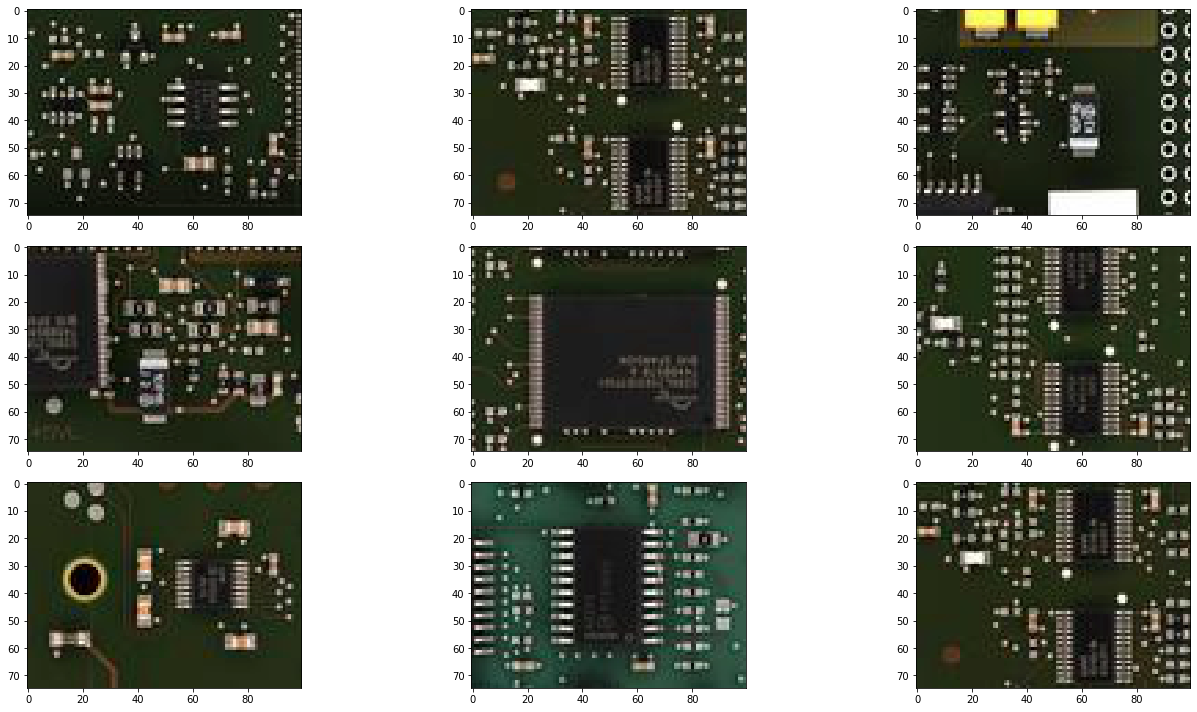

In [8]:
# Plot random Images from the Dataset 
idx = np.random.randint(low=0, high=X.shape[0], size=9)

fig, axes = plt.subplots(3,3, figsize = (20,10))
for i in range(3):
    for j in range(3):
        axes[i][j].imshow((X[idx[i*3+j]]+1)/2)
plt.tight_layout()
plt.show()

In [39]:
# Utilities functions
def _save_discriminator_summary(summary: str):
    """ Internal function to save the summary() of discriminator in file
    
    Function utilies that can be put as argument in the model.summary() function 
    to save the output as a .txt file
    
    Args:
        summary (str): Summary of the model.
    """
    with open('models/discriminator_summary.txt','a') as f:
        f.write(summary)
        f.write("\n")

def _save_generator_summary(summary: str):
    """ Internal function to save the summary() of generator in file
    
    Function utilies that can be put as argument in the model.summary() function 
    to save the output as a .txt file
    
    Args:
        summary (str): Summary of the model.
    """
    with open('models/generator_summary.txt','a') as f:
        f.write(summary)
        f.write("\n")

### Discriminator
> Function to create a discriminator model based on the template structure implemented. 
    The function allows the dynamic setting of some parameters for the models for grid search purporses. 
    Also, the function prints the summary of the model in a .txt file (see _save_discriminator_summary function) for report purposes.

In [10]:
# define the standalone discriminator model
def discriminator_creation(input_shape : list = (75, 100, 3), dropout_ratio : float = 0.5, 
                         batch_norm_momentum : float = 0.8, adam_learning_rate : float = 0.0002):
    """ Discriminator template structure
    
    Function to create a discriminator model based on the template structure implemented. 
    The function allows the dynamic setting of some parameters for the models for grid search purporses. 
    The function also print the summary of the model in a .txt file (see _save_discriminator_summary function)
    
    Args : 
        input_shape (list) : input shape of the image
        dropout_ratio (float) : ratio setting of all the dropout layers in the model
        batch_norm_momentum (float) : momentum setting of all the batch norm layers in the model
        adam_learning_rate (float) : learning rate for the adam optimizer
    
    Returns : 
        d_model (Tensorflow model) : Compiled discriminator model 
    """
    # Initial Weights
    init = RandomNormal(mean=0.0, stddev=0.03)
    
    d_model = Sequential(name = 'Discriminator')
    
    # Gaussian Noise to be added to input
    d_model.add(GaussianNoise(0.2, input_shape = input_shape))
    
    # Deconv Block
    d_model.add(Conv2D(128, (3,3), strides = 1, padding='same', input_shape=input_shape, kernel_initializer=init))
    d_model.add(BatchNormalization(momentum=batch_norm_momentum))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(dropout_ratio))
    
    # Deconv Block
    d_model.add(Conv2D(128, (3,3), strides = 2, padding='same', kernel_initializer=init))
    d_model.add(BatchNormalization(momentum=batch_norm_momentum))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(dropout_ratio))
    
    # Deconv Block
    d_model.add(Conv2D(128, (3,3), strides = 2, padding='same', kernel_initializer=init))
    d_model.add(BatchNormalization(momentum=batch_norm_momentum))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(dropout_ratio))
    
    # Deconv Block
    d_model.add(Conv2D(256, (5,5), strides = 2, padding='same', kernel_initializer=init))
    d_model.add(BatchNormalization(momentum=batch_norm_momentum))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(dropout_ratio))
    
    # Deconv Block
    d_model.add(Conv2D(512, (5,5), strides = 2, padding='same', kernel_initializer=init))
    d_model.add(BatchNormalization(momentum=batch_norm_momentum))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(dropout_ratio))
    
    # Output layer
    d_model.add(Flatten())
    d_model.add(Dropout(dropout_ratio))
    d_model.add(Dense(1, activation = 'sigmoid', kernel_initializer=init))
    
    # Compile 
    opt = Adam(lr=adam_learning_rate, beta_1=0.5)
    d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Print summary in file
    d_model.summary(print_fn=_save_discriminator_summary)
    
    return d_model

### Generator
> Function to create a generator model based on the template structure implemented. 
    The function allows the dynamic setting of some parameters for the models for grid search purporses. 
    Also, the function prints the summary of the model in a .txt file (see _save_generator_summary function) for report purposes.

In [17]:
# define the standalone generator model
def generator_creation(latent_dim : int, dropout_ratio : float = 0.3, 
                         batch_norm_momentum : float = 0.8):
    """ Generator template structure
    
    Function to create a generator model based on the template structure implemented. 
    The function allows the dynamic setting of some parameters for the models for grid search purporses. 
    The function also print the summary of the model in a .txt file (see _save_generator_summary function)
    
    Args : 
        latent_dim (int) : latent dimension of the generator
        input_shape (list) : input shape of the image
        dropout_ratio (float) : ratio setting of all the dropout layers in the model
        batch_norm_momentum (float) : momentum setting of all the batch norm layers in the model
    
    Returns : 
        g_model (Tensorflow model) : Uncompiled generator model 
    """
    # Initial Weights
    init = RandomNormal(mean=0.0, stddev=0.03)
    n_nodes = 15 * 20 * 512
    
    g_model = Sequential(name = 'Generator')
    
    # Initial space from the latent space
    g_model.add(Dense(n_nodes, input_dim=latent_dim, kernel_initializer=init))
    g_model.add(Reshape((15, 20, 512)))
    g_model.add(Activation('relu'))
    g_model.add(BatchNormalization(momentum=batch_norm_momentum))
    g_model.add(Dropout(dropout_ratio))
    
    # Upsampling block 
    g_model.add(UpSampling2D(size=(5, 5)))
    g_model.add(Conv2D(512, (5,5), strides=(1,1), padding='same', kernel_initializer=init))
    g_model.add(BatchNormalization(momentum=batch_norm_momentum))
    g_model.add(Activation('relu'))
    g_model.add(Dropout(dropout_ratio))
    
    # Upsampling block 
    g_model.add(UpSampling2D(size=(1, 1)))
    g_model.add(Conv2D(256, (5,5), strides=(1,1), padding='same', kernel_initializer=init))
    g_model.add(BatchNormalization(momentum=batch_norm_momentum))
    g_model.add(Activation('relu'))
    g_model.add(Dropout(dropout_ratio))
    
    # Upsampling block 
    g_model.add(UpSampling2D(size=(1, 1)))
    g_model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer=init))
    g_model.add(BatchNormalization(momentum=batch_norm_momentum))
    g_model.add(Activation('relu'))
    g_model.add(Dropout(dropout_ratio))
    
    # Upsampling block 
    g_model.add(UpSampling2D(size=(1, 1)))
    g_model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer=init))
    g_model.add(BatchNormalization(momentum=batch_norm_momentum))
    g_model.add(Activation('relu'))
    g_model.add(Dropout(dropout_ratio))
    
    # Upsampling block 
    g_model.add(UpSampling2D(size=(1, 1)))
    g_model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer=init))
    g_model.add(BatchNormalization(momentum=batch_norm_momentum))
    g_model.add(Activation('relu'))
    g_model.add(Dropout(dropout_ratio))
    
    # Final Image creation block (in RGB)
    g_model.add(UpSampling2D(size=(1, 1)))
    g_model.add(Conv2D(3, (3,3), strides=(1,1), padding='same', kernel_initializer=init))
    g_model.add(Activation('tanh'))
    
    # Print summary in file
    g_model.summary(print_fn=_save_generator_summary)
    
    return g_model

### GAN model 
 > Function to automatically generate the GAN model (composed of discriminator and generator) based on the discriminator and generator model. In this structure, we will freeze the parameters of the discriminator to train the generator only.

In [12]:
def gan_creation(generator_model, discriminator_model, adam_learning_rate : float = 0.0002):
    """ GAN template structure
    
    Function to automatically generate the GAN model (composed of discriminator and generator) based 
    on the discriminator and generator model. 
    In this structure, we will freeze the parameters of the discriminator to train the generator only.
    
    Args : 
        generator_model (Tensorflow model) : generator model
        discriminator_model (Tensorflow model) : discriminator model
        adam_learning_rate (float) : learning rate for the adam optimizer
         
    Returns : 
        gan_model (Tensorflow model) : Compiled gan model 
    """
    gan_model = Sequential()
    
    # Set discriminator subclass model as not trainable in this layer 
    discriminator_model.trainable = False
    

    gan_model.add(generator_model)
    gan_model.add(discriminator)  
    
    # Compile 
    opt = Adam(lr=adam_learning_rate, beta_1=0.5)
    gan_model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return gan_model  

__Note__ : 

In this model, the discriminator model is used as a non-trainable layer. However, during the training we will train the discriminator in standalone. It is important to highlight that it is because we __compiled__ the discriminator model (see '_discriminator_creation'_ function) __before setting it to non-trainable__ in the gan_model that the discriminator model is __trainable__ in standalone. 

However, due to the two duality of its trainable status during the training, tensorflow might send warning messages during the training part of this notebook. Therefore, those warning messages can be ignored further on.


### Utilities function for training
> Utilities function that we will use for the main training function

In [27]:
# Pick real sample from the X dataset
def _choose_random_images(X_input, n_samples, one_sided_label_smoothing = False):
    """ Output randam samples (size = n_samples) of images from X
    
    Based on the input image dataset, function will randomly choose n_samples images 
    in the dataset and output them in a numpy array file. It will also output their label : 
    1 (for True Images) or 0.9 if one-sided labelling setting is turned on. 
    
    Args: 
        X_input (numpy array) : Input dataset of images. Shape = (n_images, height, width, channel)
        n_samples (int) : number of random samples to choose from X_input
        one_sided_label_smoothing (boolean) : If set to True, will set the y value to 0.9 for 
            one-sided label smoothing effect
    Returns:
        X_samples (numpy array) : Dataset based on random images from X_input. Shape = (n_samples, height, width, channel)
        y_samples (numpy array) : Label of output images (1 or 0.9). Shape = (n_samples, 1)
    """
    
    # Choose random images
    n_images = X_input.shape[0]
    idx_random = randint(0, n_images, n_samples)
    X_random = X_input[idx_random]
    
    # Label
    if one_sided_label_smoothing : 
        y_random = np.full((n_samples, 1), 0.9)
    else : 
        y_random = np.ones((n_samples, 1))
    
    return X_random, y_random

In [28]:
# generate points in latent space as input for the generator
def _generate_latent_points(latent_dim, n_samples):
    """ Generate latent points which will serve as input for generator model
    
    Generate latent points which will serve as input for generator model. 
    The latent point are generated according to the standard normal law 
    (and not the uniform law), as recommended for GAN model
    
    Args : 
        latent_dim (int) : latent dimension of the generator
        n_samples (int) : number of random latent points to generate
        
    Returns : 
        z_samples (numpy array) : array of random latent points that will serve as input for the 
            generator model. Shape = (n_samples, latent_dim)
    """
    
    z_samples = randn(latent_dim * n_samples)
    z_samples = z_samples.reshape(n_samples, latent_dim)
    
    return z_samples

# Based on generator, create fake images
def _generate_fake_images(generator_model, latent_dim, n_samples):
    """ Generate fake images based on the Generator model 
    
    Based on the generator model, the function will randomly generate n_samples fake images 
    and output them in a numpy array file. It will also output their label 0 for Fake images
    
    Args : 
        generator_model (Tensorflow model) : generator model
        latent_dim (int) : latent dimension of the generator
        n_samples (int) : number of fake images to generate
        
    Returns : 
        X_fake (numpy array): Fake images created by generator. Shape = (n_samples, height, width, channel)
        y_fake (numpy array) : Label of output images (0 for Fake). Shape = (n_samples, 1)
    """
    # generate points in latent space
    z = _generate_latent_points(latent_dim, n_samples)
    
    # Create fake images
    X_fake = generator.predict(z)
    
    # Label
    y_fake = np.zeros((n_samples, 1))
    
    return X_fake, y_fake

### Train function 

In [41]:
# Custom Train function for GAN  
def train_gan(g_model, d_model, gan_model, 
              X_input, latent_dim, n_epochs, n_batch, 
              one_sid_lab_smooth = False, saving_frequency = -1, 
              checkpoint_model_path = './models/', model_version = 0):
    """ Custom training function for the GAN architecture
    
    Custom function which will follow the GAN structure to train consecutively the discriminator 
    and generator for the number of given epochs. The function allow to enable the One-sided 
    label smoothing effect and provide checkpoint model saving functionality (discriminator and generator)
    for multiple possible version
    
    Args :
        g_model (Tensorflow model) : Generator model 
        d_model (Tensorflow model) : Discriminator model
        gan_model (Tensorflow model) : GAN model
        latent_dim (int) : latent dimension of the generator
        n_epochs (int) : number of epochs for the training
        n_batch (int) : batch size 
        one_sid_lab_smooth (boolean) : If set to True, will enable the one sided label smoothing 
            effect (see _choose_random_images function)
        saving_frequency (int) : Epochs frequency for which the models are saved (discriminator 
            and generator). 
            If set to 0, they will be no saving during training. 
            If set to -1, only the last epochs will be sabed
        checkpoint_model_path (str) : Path to which the models will be saved
        model_version (int) : if different from 0, create sub-folder to which the models are saved
    
    Returns : 
        [g_model] (set model file): Set of saved generator model file
        [d_model] (set model file): Set of saved discriminator model file
    """
    
    # Init path for checkpoint saving (if requested)
    if saving_frequency == 0 :
        pass
    else : 
        if model_version < 1 : 
            save_path = checkpoint_model_path
        else : 
            save_path = f'{checkpoint_model_path}version_{model_version}/'
        
        # Check if folder exist and create it if not
        if not os.path.isdir(save_path) :
            os.mkdir(save_path)
            
    
    # Define number of batch 
    bat_per_epo = int(X_input.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # List of Loss function - for tracking and checking purposes 
    discri_loss_real_lst = []
    discri_loss_fake_lst = []
    generator_loss_lst = []
    
    # Epoch training
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # Samples real and fake
            X_real, y_real = _choose_random_images(X_input, half_batch, 
                                                   one_sided_label_smoothing=one_sid_lab_smooth)
            X_fake, y_fake = _generate_fake_images(g_model, latent_dim, half_batch)
            
            # Discriminator Training
            discri_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            discri_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            discri_loss_real_lst.append(discri_loss_real)
            discri_loss_fake_lst.append(discri_loss_fake)

            # New set of latent points for Generator training (target label are 1)
            z_latent_points = _generate_latent_points(latent_dim, n_batch)
            y_latent_points = np.ones((n_batch, 1))
            
            # Generator training
            generator_loss = gan_model.train_on_batch(z_latent_points, y_latent_points)
            
            generator_loss_lst.append(generator_loss)

            print(f'>Ep:{i+1}, Batch:{j+1}/{bat_per_epo}, d_loss_r={discri_loss_real:.3f}, d_loss_f={discri_loss_fake:.3f}, g_loss={generator_loss:.3f}')

            if (i>=1) and (j==0):
                print('mean d_loss_r : ', np.mean(discri_loss_real_lst), 'std : ', np.std(discri_loss_real_lst))
                print('mean d_loss_f : ', np.mean(discri_loss_fake_lst), 'std : ', np.std(discri_loss_fake_lst))
                print('mean g_loss   : ', np.mean(generator_loss_lst), 'std : ', np.std(generator_loss_lst))
                discri_loss_real_lst = []
                discri_loss_fake_lst = []
                generator_loss_lst = []
            
        # Checkpoint model saving 
        if saving_frequency < 1 : 
            pass
        else : 
            if (i%saving_frequency)==0:
                g_model.save(f'{save_path}generator-epoch{i}-ltDim{latent_dim}.hdf5')
                d_model.save(f'{save_path}discriminator-epoch{i}-ltDim{latent_dim}.hdf5')
    
    # Save last epochs
    if (saving_frequency != 0): 
        g_model.save(f'{save_path}generator-epoch{i}-ltDim{latent_dim}.hdf5')
        d_model.save(f'{save_path}discriminator-epoch{i}-ltDim{latent_dim}.hdf5')

__Note__ 

It is important to highlight that even if no saving input is set in the training, the input models will still be trained. However, since GANs are know to have unstable training issue, we highly recommend to make checkpoint save to monitor if and when model collapse. 

## Model Creation and Training 

In [43]:
# Init constant
latent_dim = 100

# Create model
discriminator = discriminator_creation()
generator = generator_creation(latent_dim = latent_dim)
gan = gan_creation(generator, discriminator)

In [ ]:
# Parameters training
save_fr = 5
lab_smoothing = True
model_version = 0 
epochs = 200
batch_size = 32

train_gan(generator, discriminator, gan, X_input = X, latent_dim = latent_dim, 
          n_epochs = epochs, n_batch = batch_size, one_sid_lab_smooth = lab_smoothing, 
          saving_frequency = save_fr)